In [1]:
import sys
sys.path.insert(0, "/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages")
sys.path.append('/afs/ir/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/util')
print sys.path
import lasagne
print lasagne.__version__

from data_utils import get_CIFAR10_data

!export THEANO_FLAGS='floatX=float32'


['/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages', '', '/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/lib/python2.7', '/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/lib/python2.7/plat-x86_64-linux-gnu', '/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/lib/python2.7/lib-tk', '/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/lib/python2.7/lib-old', '/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/lib/python2.7/lib-dynload', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/local/lib/python2.7/site-packages', '/afs/ir/users/c/j/cjbillov/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages',

In [2]:
# Autoencoder

import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import theano
import theano.tensor as T
from theano import pp
import time

import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer, InverseLayer

from lasagne.utils import floatX
from lasagne.updates import adam
from lasagne.nonlinearities import softmax



/afs/ir.stanford.edu/users/c/j/cjbillov/cs231n/project/CS231N-FinalProject/.env/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
data = np.array( np.random.random((1024, 128)), dtype=np.float32)

img_data = get_CIFAR10_data()

In [4]:
# for k, v in img_data.iteritems():
#   print '%s: ' % k, v.shape

X_val = img_data['X_val']
X_val = np.array( X_val.reshape((1000, -1)), dtype=np.float32)
print X_val.shape
data = X_val
y = data 

(1000, 3072)


In [6]:
# Make lasagne layers

input_var = T.matrix('inputs')
target_var = T.matrix('targets')

net = {}
net['input'] = InputLayer ((None, 3072), input_var=input_var)
net['h1'] = DenseLayer(net['input'], num_units=2048, nonlinearity=lasagne.nonlinearities.tanh,
                                       W=lasagne.init.HeNormal(gain=1.0) )
net['h2'] = DenseLayer(net['h1'], num_units=1024, nonlinearity=lasagne.nonlinearities.tanh, 
                                       W=lasagne.init.HeNormal(gain=1.0) )

net['h2_inv'] = InverseLayer(net['h2'], net['h2'])
net['h1_inv'] = InverseLayer(net['h2_inv'], net['h1'])

# l1 = InputLayer((None, 784))
# l2 = DenseLayer(l1, num_units=500, nonlinearity=lasagne.nonlinearities.rectify, )
# l3 = InverseLayer(l2, l2)



In [7]:
params = lasagne.layers.get_all_params(net['h1_inv'], trainable=True)
out = lasagne.layers.get_output(net['h1_inv'], deterministic=True)

loss = lasagne.objectives.squared_error(out, target_var)
adam_update = adam (loss.mean(), params)

train_function = theano.function([input_var, target_var], loss, updates=adam_update)

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    """
    Get minibatch for data.
    :param inputs:
    :param targets:
    :param batchsize:
    :param shuffle:
    :return:
    """
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [9]:
def train(x=data, y=data, num_epochs=20):
    batch_size = 100
    print x.dtype
    print y.dtype
    print("Starting training...")
    # We iterate over epochs:
    for epoch in range(num_epochs):
        # In each epoch, we do a full pass over the training data:
        train_err = 0.0
        train_batches = 0
        start_time = time.time()
        for batch in iterate_minibatches(x, y, batch_size, shuffle=True):
            inputs, targets = batch
            train_function(inputs, targets)
            train_batches += 1
        print 'epoch {0} done in time {1}'.format(epoch, time.time() - start_time)
    
    

In [ ]:
train(data, y)

float32
float32
Starting training...
epoch 0 done in time 14.7442781925
epoch 1 done in time 15.1257050037

In [46]:
param_values = lasagne.layers.get_all_param_values(net['h1_inv'])
W1, b1, W2, b2 = param_values
print W1.shape, W2.shape

(3072, 1024) (1024, 256)


In [11]:
compressed = np.array(lasagne.layers.get_output(net['h1_inv'], data, deterministic=True).eval())


In [12]:
compressed = compressed.reshape((1000, 3, 32, 32))
print compressed.shape

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

(1000, 3, 32, 32)


(3, 32, 32)
(1000, 32, 32, 3)
(1000, 32, 32, 3)


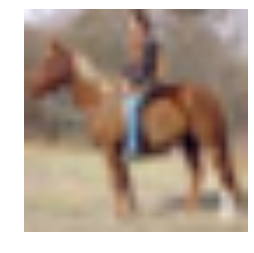

In [56]:
%matplotlib inline
print compressed[0].shape

print normed_data.shape


normed_data = data.reshape((1000, 3, 32, 32))
normed_data = np.transpose(normed_data, (0, 2, 3, 1))
print normed_data.shape

# #imshow_noax(compressed[0])
imshow_noax(normed_data[10])
#imshow_noax(np.transpose(compressed[0], (1, 2, 0)))

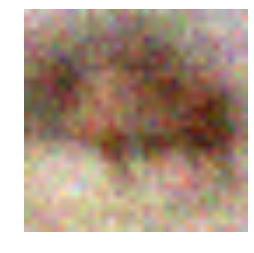

In [57]:
imshow_noax(np.transpose(compressed[10], (1, 2, 0)))